Run this to make sure the DL at the end works.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Mount drive and change to working directory.

In [2]:
from google.colab import drive
drive.mount("/content/drive/")
%cd 'drive/My Drive/MIR/CH-818'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/MIR/CH-818


Load Chinese Dataset (CH-818 - songs from 4 emotion classes in the AV plane) - !!! Go straight to "Load .csv files into DataFrames." if you want to load directly the pre-extracted features.

In [0]:
import pandas as pd
import os

# Read excel file with annotations of CH-818
data = pd.read_excel('CH818.xlsx')
labels = data['Quads'].tolist()

# Read all music files
path = 'ch818_mp3'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.mp3' in file:
            files.append(os.path.join(r, file))

# Dictionary containing for each emotion class a list that carries dictionaries
inst_files = dict() 
for i, file in enumerate(files):
    emotion = labels[i]
    files_emotion = inst_files.get(emotion)
    file_name = os.path.join(file)
    if files_emotion == None:
        files_emotion = [file_name]
    else:
        files_emotion.append(file_name)
    inst_files[emotion] = files_emotion

Plot sample waveform for each emotion class.

     |████████████████████████████████| 11.7MB 3.5MB/s 
Sample waveform plots


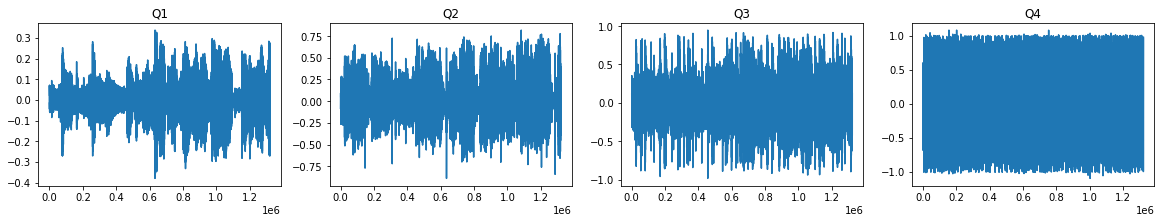

In [4]:
# Raw-data preprocess analysis parameters
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import matplotlib.pyplot as plt
import essentia.standard as ess

fs = 44100
num_emotion = len(inst_files.keys())
print("Sample waveform plots")
plt.figure(1, figsize=(5 * num_emotion, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
keys_order = ['Q1', 'Q2', 'Q3', 'Q4']
for i,emotion in enumerate(keys_order):
    sample_file = inst_files[emotion][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()   
    plt.subplot(1,num_emotion,(i+1))
    plt.plot(x)
    plt.title(emotion)

Check if dataset is balanced.

In [5]:
# Check data is balanced
for key in keys_order:
    print(key, ': ', len(inst_files[key]), ' samples \n')

Q1 :  391  samples 

Q2 :  127  samples 

Q3 :  211  samples 

Q4 :  89  samples 



Balance data

In [6]:
inst_files['Q1'] = inst_files['Q1'][:89]  
inst_files['Q2'] = inst_files['Q2'][:89]  
inst_files['Q3'] = inst_files['Q3'][:89]  
for key in keys_order:
    print(key, ': ', len(inst_files[key]), ' samples \n')

Q1 :  89  samples 

Q2 :  89  samples 

Q3 :  89  samples 

Q4 :  89  samples 



Split samples into train set and test set.

In [7]:
# Put into X and y arrays.
X = []
y = []
for emotion, files in inst_files.items():
    for file in files:
        X.append(file)
        y.append(emotion)

# Split data into test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("Size of train set: ", len(X_train), ", Size of train output vector: ", len(y_train))
print("Size of test set: ", len(X_test), ", Size of test output vector: ", len(y_test))

Size of train set:  284 , Size of train output vector:  284
Size of test set:  72 , Size of test output vector:  72


Divide each sample into 4 segments and save them to appropriate train or test segments folder. - !!! The next 2 cells take some time to run, you can straight to "Load .csv files into DataFrames." if the segments folders are already created.

In [8]:
# Create segments
import numpy as np

main_data_dir = 'ch818_mp3'
train_segments_dir = os.path.join(main_data_dir,'train_segments')
if not os.path.exists(train_segments_dir):#creating the directory
    os.mkdir(train_segments_dir)
test_segments_dir = os.path.join(main_data_dir,'test_segments')
if not os.path.exists(test_segments_dir):#creating the directory
    os.mkdir(test_segments_dir)

fs = 44100
file_count = 0
train_segment_files = []
test_segment_files = []
for i, file in enumerate(X):
    emotion = y[i]
    segments_dir = train_segments_dir if file in X_train else test_segments_dir
    x = ess.MonoLoader(filename = file, sampleRate = fs)()
    #Split song in 4 segments 
    split = (int)(len(x)/4)
    x_seg = [x[:split], x[split:2*split], x[2*split:3*split], x[3*split:]]
    for seg in x_seg:
        #Amplitude normalisation
        seg = seg / np.max(np.abs(seg))
        filename = os.path.join(segments_dir, emotion + '_' + str(file_count) + '.wav')
        ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(seg)
        file_count +=1
        train_segment_files.append(filename) if file in X_train else test_segment_files.append(filename)
print(len(train_segment_files),'segment files created')
print(len(test_segment_files),'segment files created')

1136 segment files created
288 segment files created


Feature extraction with Essentia - only low level descriptors are used.

In [0]:
#Running music extractor for a file
file = train_segment_files[0]#simply pick the first file in the list
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]

#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(train_segments_dir,'train_data.csv')
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['emotion']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in train_segment_files:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            emotion = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + emotion + '\n'
            writer.write(line2write)
# same for test set
data_file = os.path.join(test_segments_dir,'test_data.csv')
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['emotion']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in test_segment_files:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            emotion = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + emotion + '\n'
            writer.write(line2write)

Load .csv files into DataFrames.

In [10]:
# Analysis of features
import pandas as pd

train_file = 'ch818_mp3/train_segments/train_data.csv' # Uncomment this if .csv already created
test_file = 'ch818_mp3/test_segments/test_data.csv' # Uncomment this if .csv already created
#Read data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
print("Data is null:")
print(train_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan
print(test_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan

Data is null:
0
0


Normalize features.

In [0]:
# Normalization of features
train_data_modif = train_data.copy()
test_data_modif = test_data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
train_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(train_data.iloc[:,:84].values)
test_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(test_data.iloc[:,:84].values)

Check how balanced is the data in train set.

In [12]:
print(train_data_modif.emotion.value_counts())

q1    304
q4    284
q2    284
q3    264
Name: emotion, dtype: int64


In [13]:
# Balancing data
data_modif = train_data_modif
min_number = data_modif.emotion.value_counts()['q3']
q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number)
q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number, random_state = 42)
q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)

#Merging after downsampling
train_data_modif = pd.concat([q1_data, q2_data, q3_data, q4_data])
#Checking the balance again
train_data_modif.emotion.value_counts()

q4    264
q3    264
q2    264
q1    264
Name: emotion, dtype: int64

Feature selection

In [14]:
import numpy as np
from numpy import set_printoptions

# Preparing data arrays for features and labels
#input values put in a matrix, there are 84 features
X_train = train_data_modif.iloc[:,:84].values 
X_test = test_data_modif.iloc[:,:84].values 
#Creating output values
train_data_modif.emotion = pd.Categorical(train_data_modif.emotion)#convert to categorical data
test_data_modif.emotion = pd.Categorical(test_data_modif.emotion)#convert to categorical data
y_train = np.array(train_data_modif.emotion.cat.codes) #create label encoded outputs
y_test = np.array(test_data_modif.emotion.cat.codes) #create label encoded outputs

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2

z = SelectKBest(chi2, k=50)
fit = z.fit(X_train, y_train)
# summarize scores
set_printoptions(precision=3)
ten = fit.scores_.argsort()[-10:][::-1] # 10 best features selected 

X_train = fit.transform(X_train)
X_test = fit.transform(X_test)   # only consider selected features from the training set
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape, '\n')

print('Top 10 selected features: ')
for i in ten:
    print(train_data_modif.keys()[i])

X_train shape is  (1056, 50)
X_test shape is  (288, 50) 

Top 10 selected features: 
spectral_energyband_middle_high.mean
spectral_centroid.mean
silence_rate_30dB.stdev
barkbands_spread.mean
spectral_energyband_middle_high.stdev
melbands_spread.mean
melbands_kurtosis.mean
barkbands_flatness_db.mean
zerocrossingrate.mean
spectral_rolloff.mean


Analysis of best 2 features

Silence rate 20dB stdev x Silence rate 60dB stdev:


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


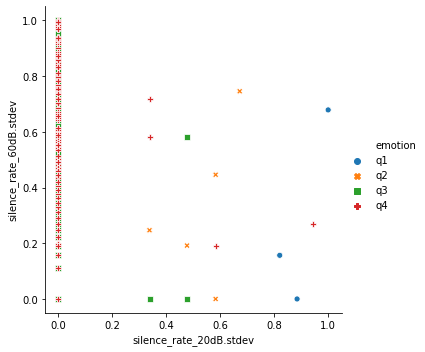

In [15]:
# Plot samples on two-dimensional feature spaces to check if features are discriminative
import seaborn as sns

print("Silence rate 20dB stdev x Silence rate 60dB stdev:")
sns.relplot(x = "silence_rate_20dB.stdev", y = "silence_rate_60dB.stdev", hue = "emotion", style = "emotion", data = train_data_modif);

Comparison of traditional Machine Learning Classifiers - !!! This cell takes some time to run - the best model is implemented in the next cell.

In [16]:
import warnings
warnings.filterwarnings('ignore')#suppress warnings
#importing various classifiers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma = 1 / (X_train.shape[-1] * X_train.var())),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    RandomForestClassifier(max_depth=15, random_state=0)]

names = ["KNN", "Linear SVM", "RBF SVM", "Gaussian Process","Neural Net", "Naive Bayes", "Random Forest"]

#Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []

#Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 1/num_tests, random_state = iteration_number)
    #normalisation of the data (learned from training data, applied to test data)
    scaler = StandardScaler().fit(x_train_val)
    norm_x_train = scaler.transform(x_train_val)
    norm_x_val = scaler.transform(x_val)
    
    # test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_train, y_train_val)#train
        score = clf.score(norm_x_val, y_val)#test
        scores[name].append(score)

for name, score in scores.items():
    print("{0}: acc = {1:1.2f}, +-{2:1.2f},\tvalues: {3}".format(name, np.mean(score), np.std(score), np.around(score, decimals = 2)))

KNN: acc = 0.48, +-0.05,	values: [0.52 0.46 0.46 0.51 0.52 0.5  0.47 0.39 0.55 0.38]
Linear SVM: acc = 0.27, +-0.04,	values: [0.27 0.26 0.23 0.31 0.24 0.31 0.24 0.34 0.28 0.26]
RBF SVM: acc = 0.49, +-0.04,	values: [0.49 0.45 0.48 0.58 0.53 0.43 0.52 0.46 0.47 0.46]
Gaussian Process: acc = 0.21, +-0.02,	values: [0.22 0.2  0.22 0.23 0.21 0.17 0.23 0.23 0.2  0.22]
Neural Net: acc = 0.45, +-0.06,	values: [0.44 0.43 0.46 0.5  0.43 0.43 0.45 0.31 0.58 0.42]
Naive Bayes: acc = 0.27, +-0.04,	values: [0.21 0.27 0.33 0.29 0.21 0.26 0.31 0.29 0.24 0.24]
Random Forest: acc = 0.47, +-0.04,	values: [0.44 0.42 0.48 0.54 0.53 0.47 0.42 0.44 0.53 0.46]


Report results for the best classifier

Number of test samples:  288
              precision    recall  f1-score   support

           0       0.25      0.46      0.33        52
           1       0.30      0.29      0.29        72
           2       0.41      0.30      0.35        92
           3       0.25      0.18      0.21        72

    accuracy                           0.30       288
   macro avg       0.30      0.31      0.29       288
weighted avg       0.31      0.30      0.30       288

Confusion matrix: 



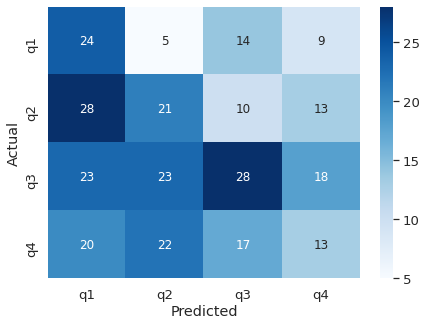

In [17]:
from sklearn.neighbors import KNeighborsClassifier
selected_model = KNeighborsClassifier(7)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

Deep Learning

In [18]:
# Define deep learning architecture
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

Using TensorFlow backend.


Shuffle train data and apply one hot encoding to output values.

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train_val, y_train_val = shuffle(X_train, y_train, random_state=13)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (1056, 4)
One-hot encoded y_test shape =  (288, 4)


Run DL model





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 50)                200       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 40)                2040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 20)                820       
_

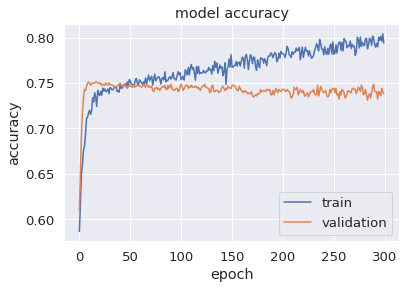

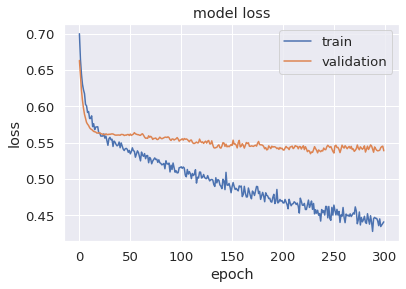

In [20]:
model = compose_model(X_train_val.shape[1])
model.summary()

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 80, epochs = 300, validation_split=0.2, verbose=0,)

# Test
score = model.evaluate(X_test, y_test_onehot, batch_size = 80, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
 
# Check the learning curves
# summarize history for accuracy
plt.plot(summary.history['acc'])
plt.plot(summary.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       0.18      0.38      0.25        52
           1       0.25      0.42      0.31        72
           2       0.40      0.23      0.29        92
           3       0.57      0.06      0.10        72

    accuracy                           0.26       288
   macro avg       0.35      0.27      0.24       288
weighted avg       0.37      0.26      0.24       288

Confusion matrix: 



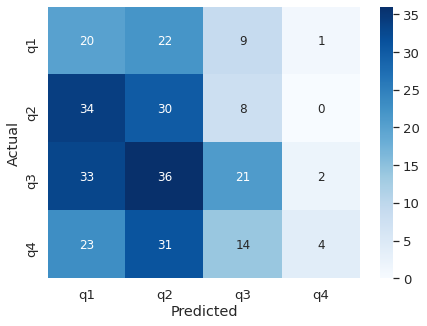

In [21]:
y_pred = model.predict_classes(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");